### Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [92]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
from scipy.stats import uniform
from scipy.optimize import curve_fit
import corner
from IPython.display import display, Math
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import warnings
warnings.filterwarnings("ignore")

In [3]:
dati = np.load('C:/Users/hp/.spyder-py3/astrostatistics_bicocca_2024/solutions/transient.npy')

In [4]:
#using where allows me to use arrays
def burst_model(x, A, b, alpha, t_0):
    y = np.where(x < t_0, b, b+A*np.exp(-alpha*(x-t_0)))
    return y

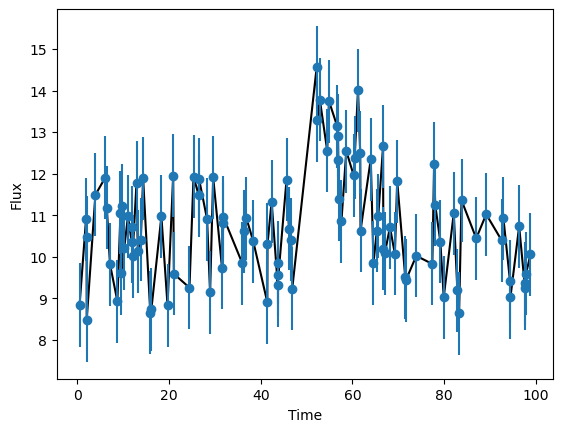

In [40]:
#plotting datas
time, flux, error = dati[:, 0], dati[:, 1], dati[:,2]
plt.plot(dati[:, 0], dati[:, 1], color = 'black')
plt.errorbar(dati[:,0], dati[:,1], yerr = dati[:,2], fmt = 'o')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

In [7]:
#ML estimation of the parameters
my_guesses_burst = [10.0, 10.0, np.exp(-1), 50.0]
parameters_burst, covariance_burst = curve_fit(burst_model, time, flux, p0 = my_guesses_burst)
print('Initial guess for A: ', parameters_burst[0])
print('Initial guess for b: ', parameters_burst[1])
print('Initial guess for alpha: ', parameters_burst[2])
print('Initial guess for t_0: ', parameters_burst[3])

Initial guess for A:  4.9612257094609005
Initial guess for b:  10.287881211089104
Initial guess for alpha:  0.1189072148096274
Initial guess for t_0:  49.94497532121225


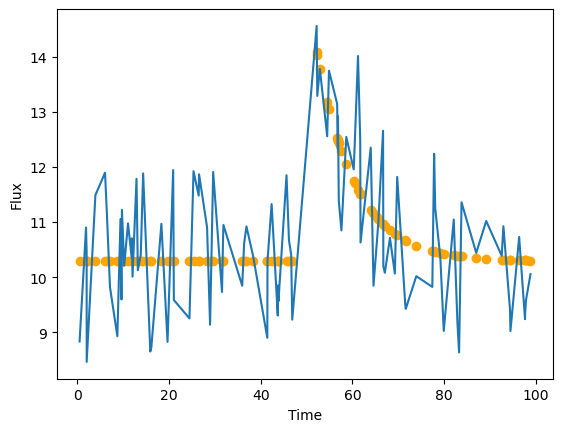

In [8]:
#check if guesses from curve_fit work well
first_fit_burst = burst_model(time, parameters_burst[0], parameters_burst[1], parameters_burst[2], parameters_burst[3])
plt.scatter(time, first_fit_burst, color = 'orange')
plt.plot(time, flux)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

17728it [01:35, 186.19it/s, batch: 7 | bound: 21 | nc: 1 | ncall: 376819 | eff(%):  4.565 | loglstar: -53.887 < -48.762 < -49.408 | logz: -63.096 +/-  0.102 | stop:  0.942]           


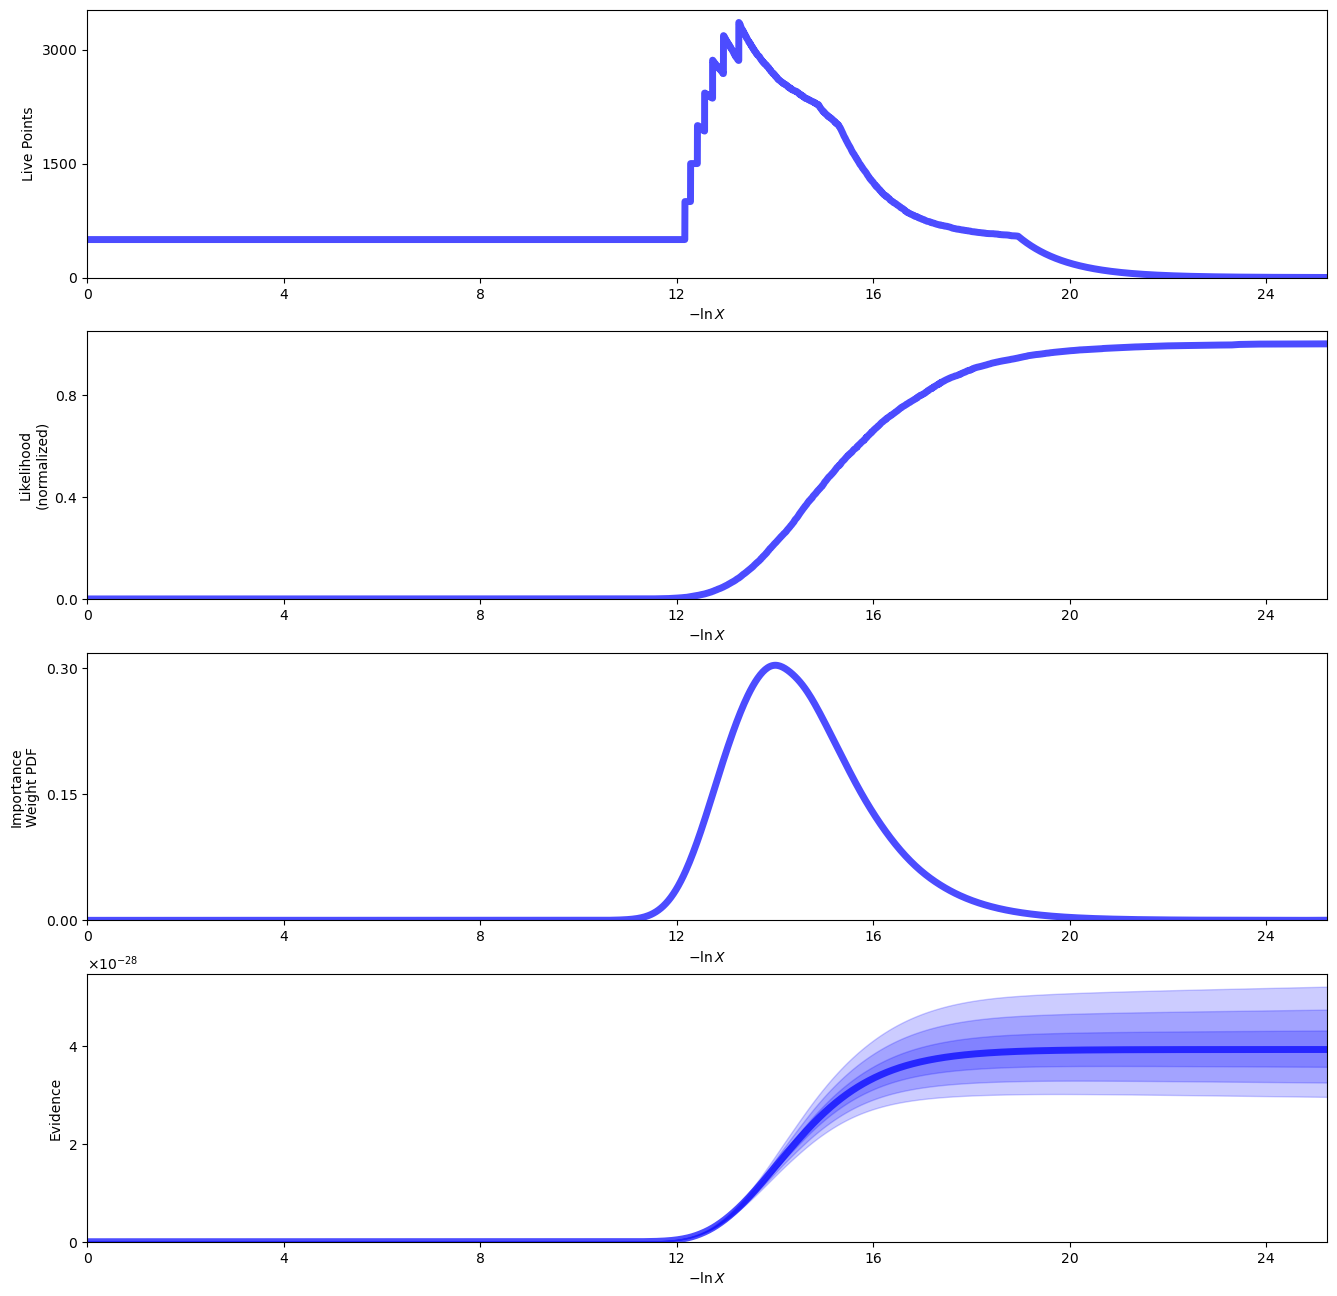

In [99]:
ndim = 4
#limits of each parameter, suggested by exercise
A_min, A_max = 0.0, 50.0
b_min, b_max = 0.0, 50.0
alpha_min, alpha_max = -5,5
t_0_min, t_0_max = 0.0, 100.0

#log likelihood as described by emcee
def log_likelihood(theta):
    A, b, alpha, t_0 = theta
    #alpha= exp logalpha
    #model = burst(theta)
    model = np.where(time < t_0, b, b+A*np.exp(-alpha*(time-t_0)))
    return -0.5 * np.sum((flux - model) ** 2 / error**2)

# Define our uniform prior via the prior transform.
def prior_transform(u):
    uA, ub, ualpha, ut_0 = u
    A = A_min + uA  *(A_max-A_min)
    b = b_min + ub*(b_max-b_min)
    alpha = np.exp((alpha_max - alpha_min)*ualpha +alpha_min)
    t_0 = t_0_min + (t_0_max-t_0_min)*ut_0
    return A,b,alpha,t_0   

# Sample from our distribution.
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim,
                                bound = 'multi', sample = 'rwalk')
sampler.run_nested()
res_burst = sampler.results

# Plot results.
fig, axes = dyplot.runplot(res_burst)

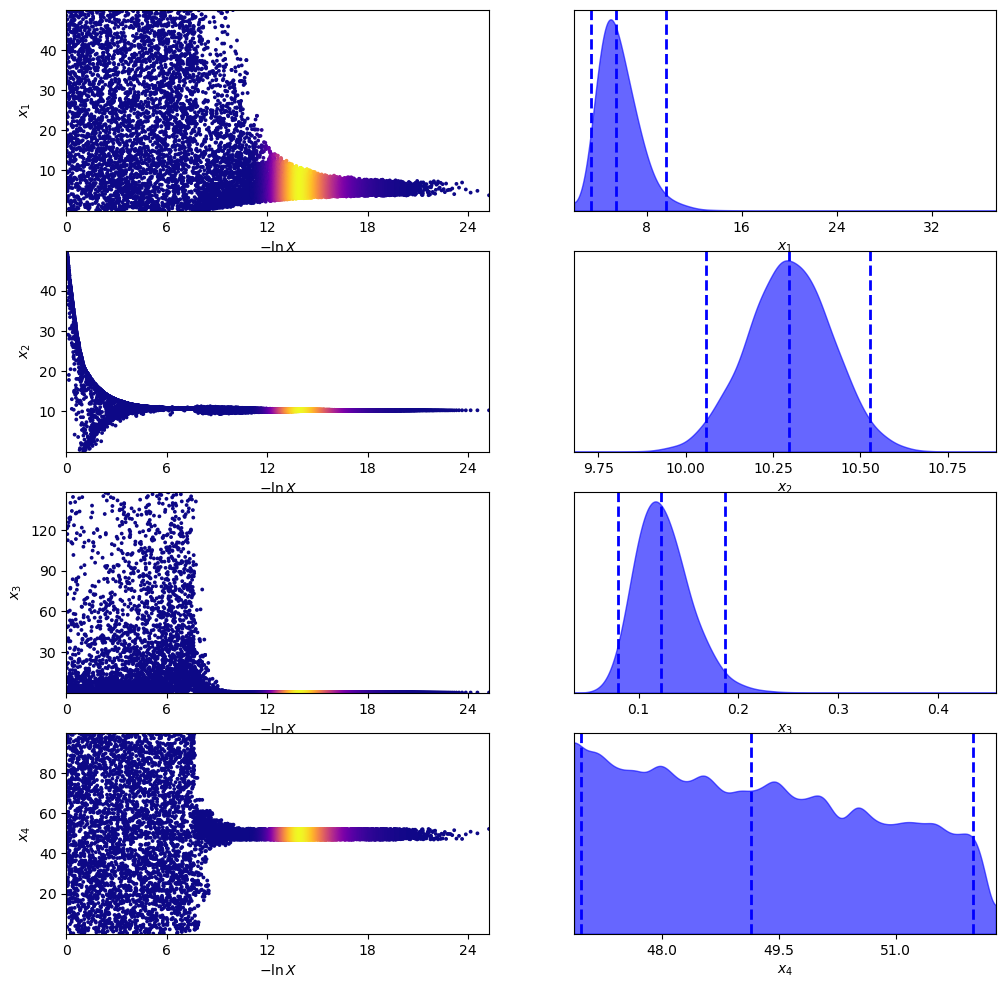

In [102]:
tfig, taxes = dyplot.traceplot(res_burst)

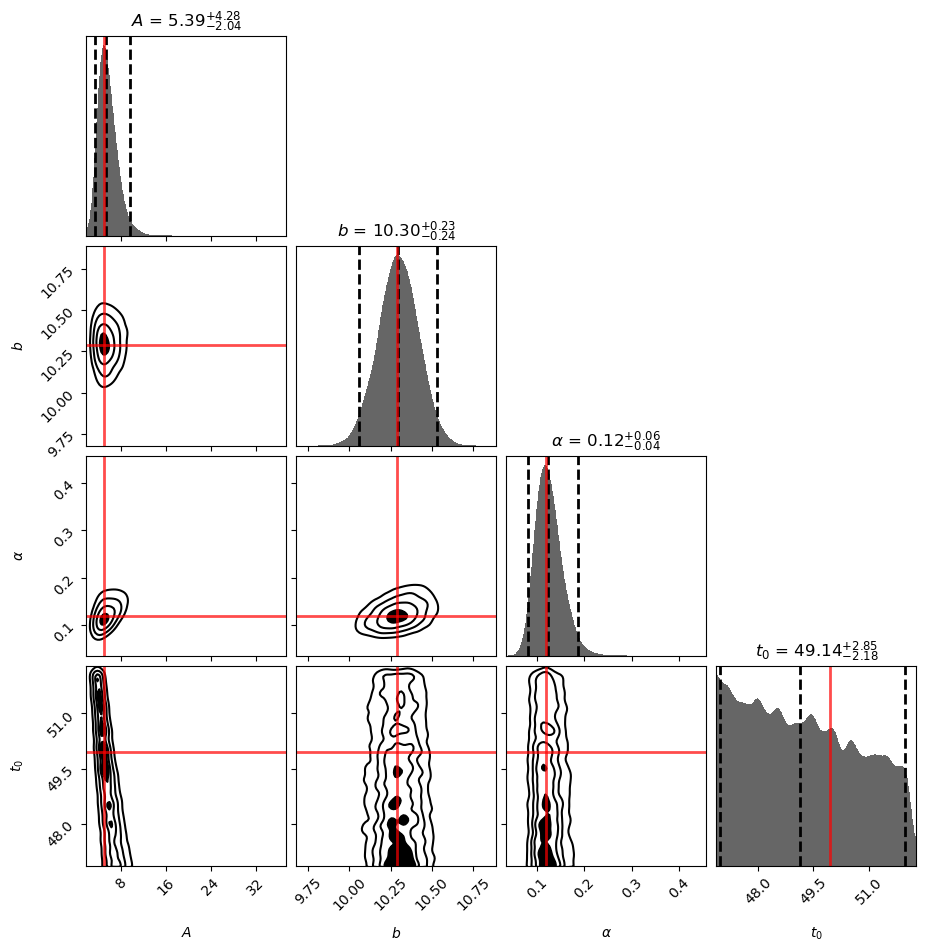

In [101]:
labels_burst = [r'$A$', r'$b$', r'$\alpha$', r'$t_0$']
cfig, caxes = dyplot.cornerplot(res_burst, labels = labels_burst, truths=parameters_burst,show_titles=True)

In [103]:
res_burst.summary()

Summary
niter: 17728
ncall: 307819
eff(%):  4.565
logz: -63.102 +/-  0.094


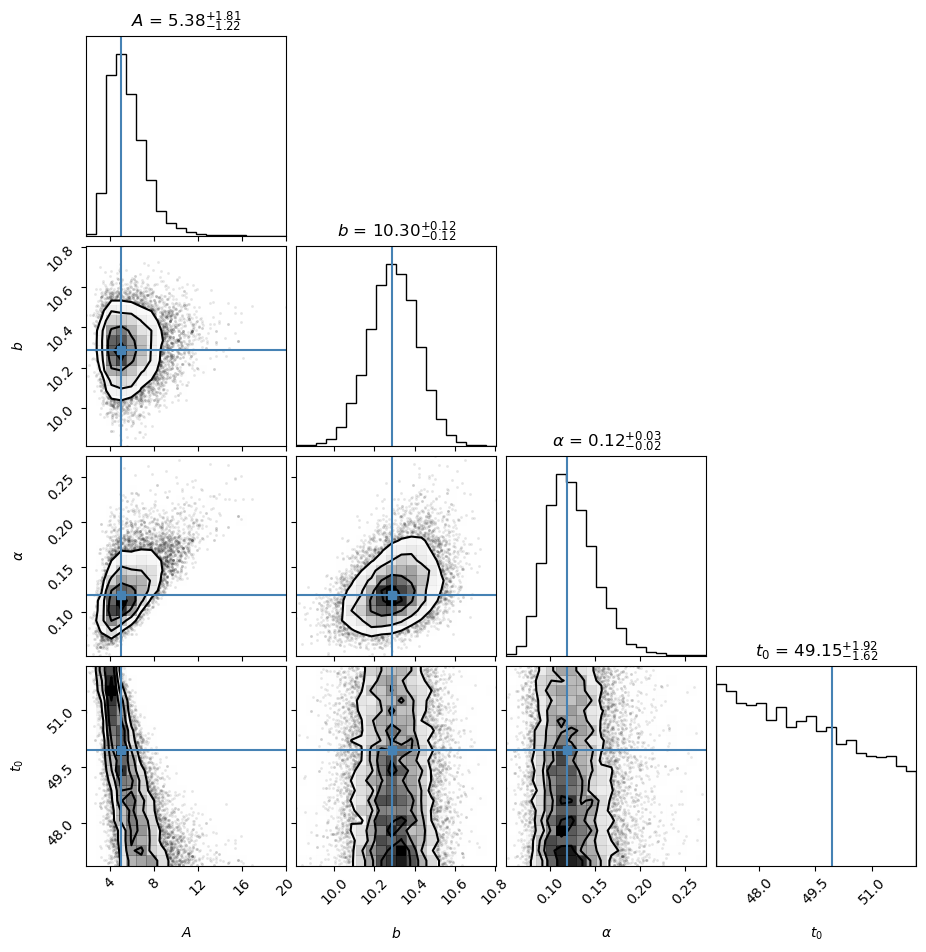

In [104]:
samples_burst = res_burst.samples
weights_burst = np.exp(res_burst.logwt - res_burst.logz[-1])  # normalized weights

samples_equal_burst = dyfunc.resample_equal(samples_burst, weights_burst)
corner.corner(samples_equal_burst,labels = labels_burst, truths=parameters_burst,show_titles=True);

In [72]:
def gauss_model(x, A, b, t_0, sigma):
    y = b + A*np.exp(-(x-t_0)**2/(2*sigma))
    return y

In [120]:
my_guesses_gauss = [5.0, 10.0, 55.0, np.exp(5)]
parameters_gauss, covariance_gauss= curve_fit(gauss_model, time, flux, p0 = my_guesses_gauss)
print('Initial guess for A: ', parameters_gauss[0])
print('Initial guess for b: ', parameters_gauss[1])
print('Initial guess for t_0: ', parameters_gauss[2])
print('Initial guess for sigma: ', parameters_gauss[3])

Initial guess for A:  2.7510743920734875
Initial guess for b:  10.306897764069294
Initial guess for t_0:  55.472592249951305
Initial guess for sigma:  28.83829259533801


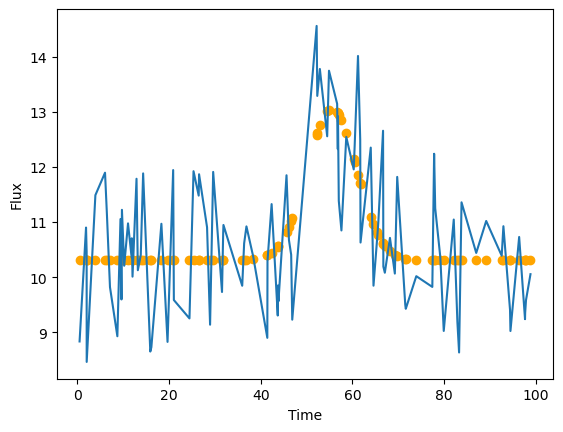

In [121]:
#check if guesses from curve_fit work well
first_fit_gauss= gauss_model(time, parameters_gauss[0], parameters_gauss[1], parameters_gauss[2], parameters_gauss[3])
plt.scatter(time, first_fit_gauss, color = 'orange')
plt.plot(time, flux)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.show()

19018it [01:37, 195.81it/s, batch: 6 | bound: 19 | nc: 1 | ncall: 407649 | eff(%):  4.537 | loglstar: -58.201 < -52.471 < -53.792 | logz: -69.049 +/-  0.110 | stop:  0.895]            


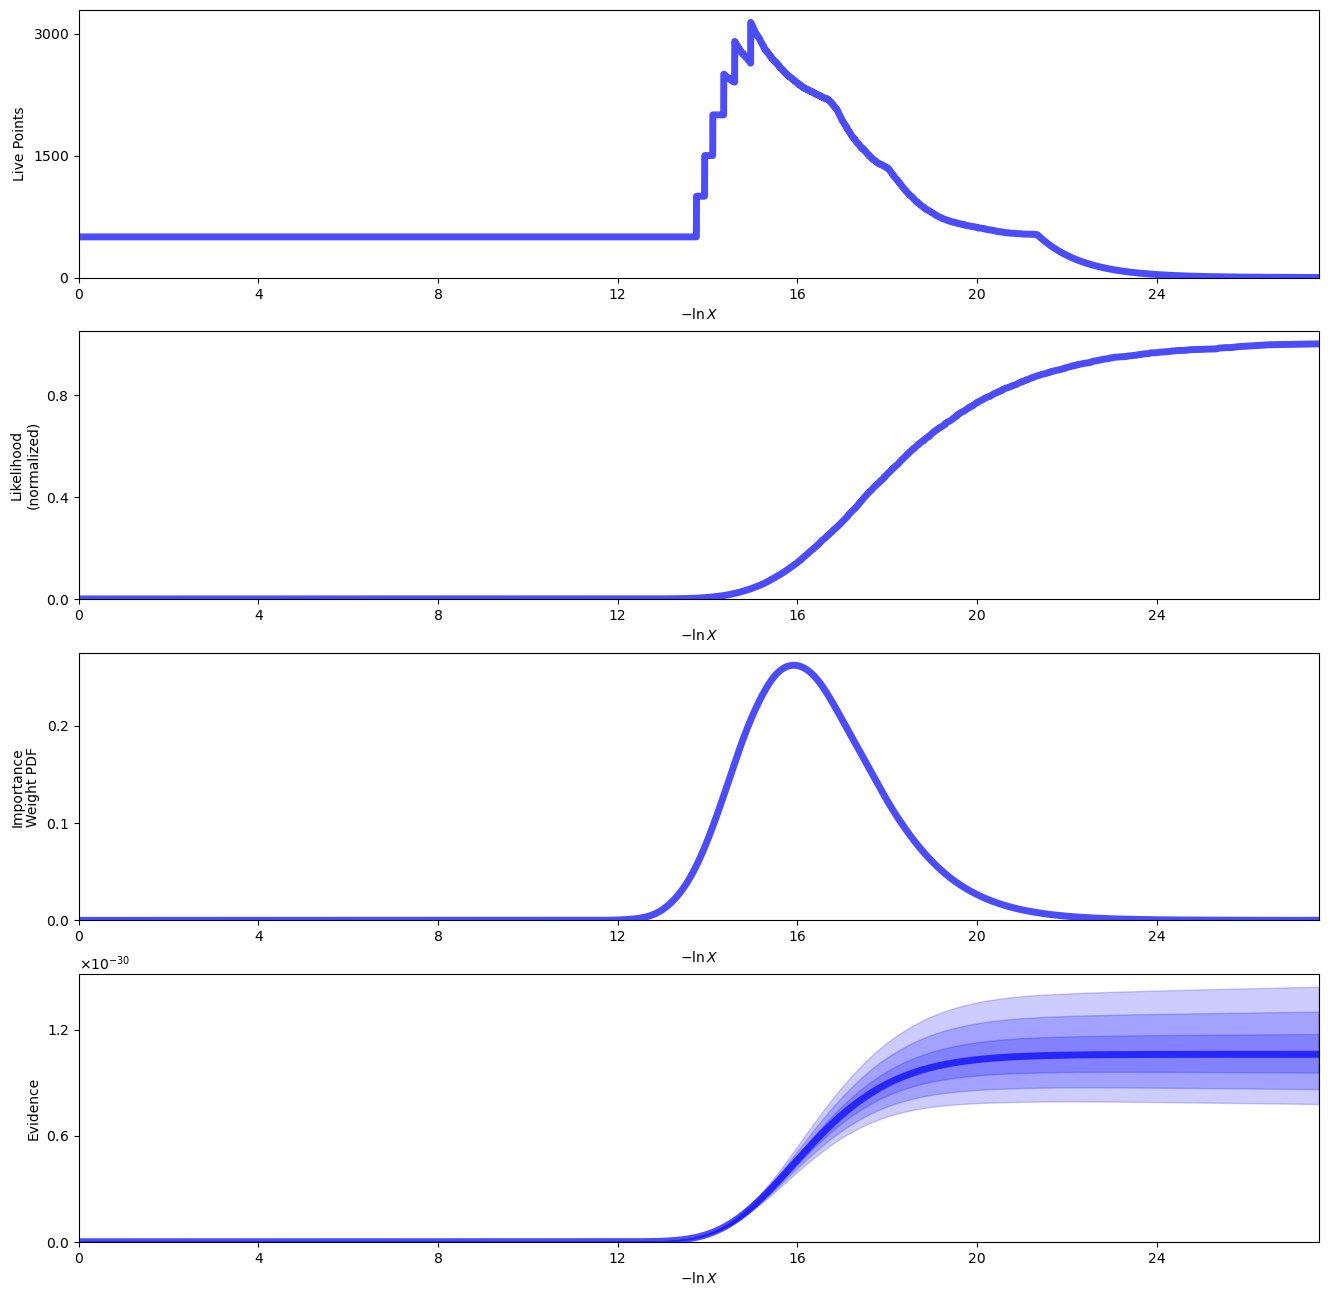

In [105]:
ndim = 4

#limits of each parameter, suggested by exercise
A_min, A_max = 0.0, 50.0
b_min, b_max = 0.0, 50.0
sigma_min, sigma_max = -5,5
t_0_min, t_0_max = 0.0, 100.0

#log likelihood as described by emcee
def log_likelihood(theta):
    A, b, sigma, t_0 = theta
    #alpha= exp logalpha
    #model = burst(theta)
    model = b + A*np.exp(-(time-t_0)**2/(2*sigma**2))
    return -0.5 * np.sum((flux - model) ** 2 / error**2)

# Define our uniform prior via the prior transform.
def prior_transform(u):
    uA, ub, usigma, ut_0 = u
    A = A_min + uA  *(A_max-A_min)
    b = b_min + ub*(b_max-b_min)
    sigma = np.exp((sigma_max - sigma_min)*usigma +sigma_min)
    t_0 = t_0_min + (t_0_max-t_0_min)*ut_0
    return A,b,sigma,t_0

# Sample from our distribution.
sampler = dynesty.DynamicNestedSampler(log_likelihood, prior_transform, ndim,
                                bound = 'multi', sample = 'rwalk')
sampler.run_nested()
res_gauss = sampler.results

# Plot results.
fig, axes = dyplot.runplot(res_gauss)

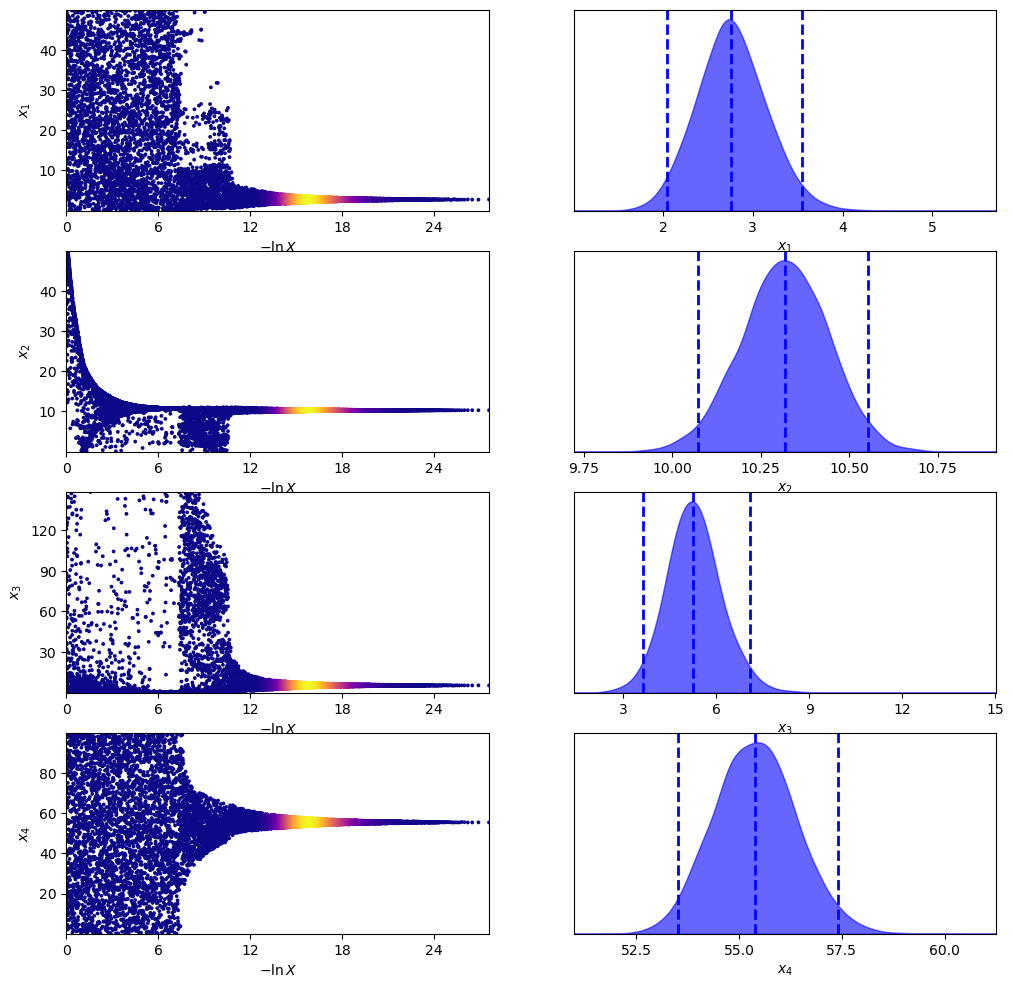

In [106]:
tfig, taxes = dyplot.traceplot(res_gauss)

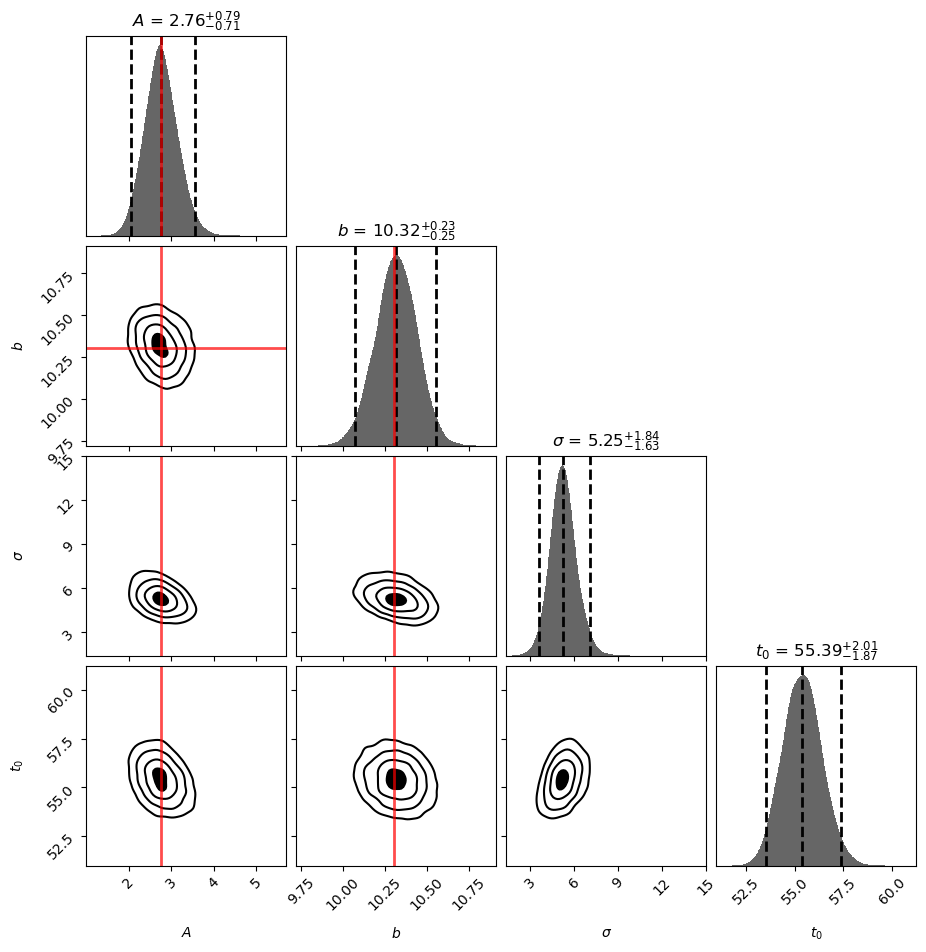

In [107]:
labels_gauss = [r'$A$', r'$b$', r'$\sigma$', r'$t_0$']
cfig, caxes = dyplot.cornerplot(res_gauss, labels = labels_gauss, truths=parameters_gauss,show_titles=True)

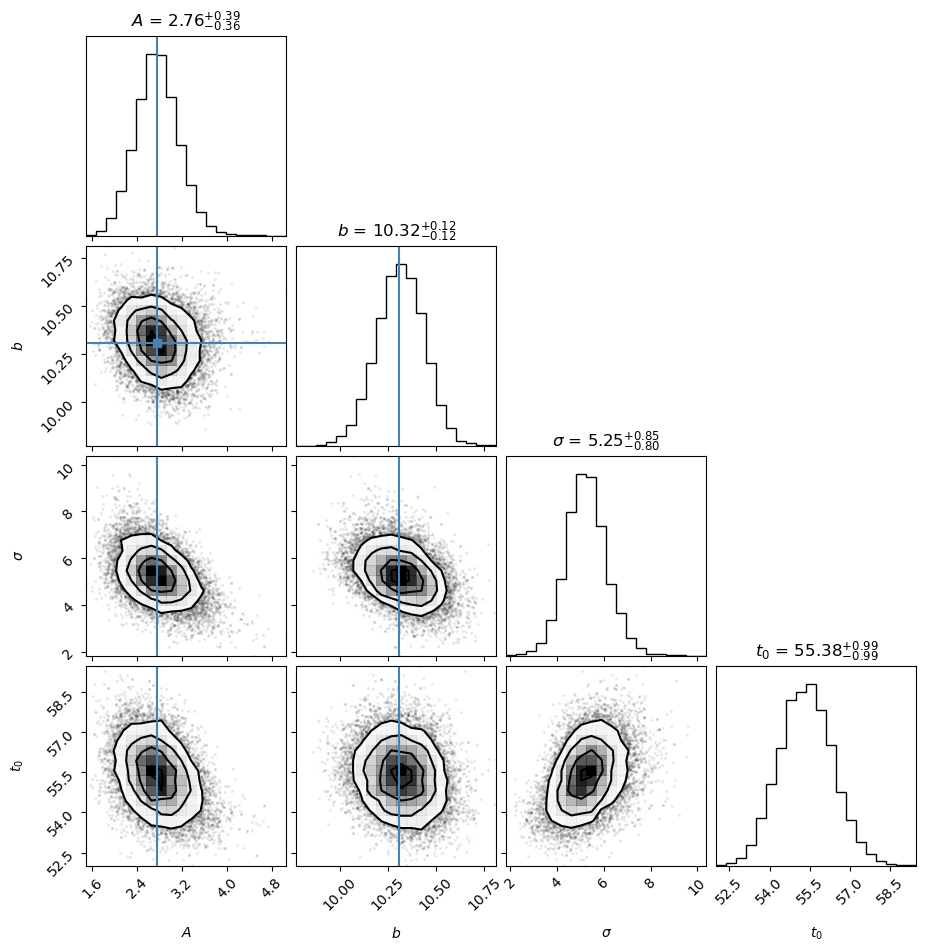

In [111]:
samples_gauss = res_gauss.samples
weights_gauss = np.exp(res_gauss.logwt - res_gauss.logz[-1])  # normalized weights

samples_equal_gauss = dyfunc.resample_equal(samples_gauss, weights_gauss)
corner.corner(samples_equal_gauss,labels = labels_gauss, truths=parameters_gauss,show_titles=True);

In [112]:
res_burst.summary()
res_gauss.summary()

Summary
niter: 17728
ncall: 307819
eff(%):  4.565
logz: -63.102 +/-  0.094
Summary
niter: 19018
ncall: 350149
eff(%):  4.537
logz: -69.019 +/-  0.103


In [113]:
print('Bayesian evidence for burst model: ', np.exp(res_burst.logz[-1]))
print('Bayesian evidence for gauss model: ', np.exp(res_gauss.logz[-1]))
print('The logarithmic Bayes factor is: ', np.log(np.exp(res_burst.logz[-1])/np.exp(res_gauss.logz[-1])))

Bayesian evidence for burst model:  3.9367500502500835e-28
Bayesian evidence for gauss model:  1.060550838817099e-30
The logarithmic Bayes factor is:  5.916737276161555


Since the logarithmic Bayes factor is > 4.6, the test is **decisive** and declares the burst model as the preferred one with respect to the gaussian.